This notebook performs group level spectral analyses for changes in theta and SWR frequency during trace conditioning. Ideally it will visual each animal side-by-side along with a combined, averaged spectrogram for each task stage.

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
# Load in / initialize sessions
import itertools
animals = ['Han', 'Rey', 'Rose', 'Django', 'Boba']
sessions = ['training']

sess_list = []
for sess_name, animal in itertools.product(sessions, animals):
    sess_dir = get_session_dir(animal, sess_name)
    sess_list.append(sess_use(sess_dir))
print(sess_list[0].recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
# Load in relevant epochs

for sess in sess_list:
    # Artifact epochs
    art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
    sess.art_epochs = Epoch(epochs=None, file=art_epochs_file)

    # CS epochs
    process_csn, process_cs, process_cs2 = True, True, True  # set flags for running code below
    if sess.basepath.name.find("habituation") == 0:
        process_cs, process_cs2 = False, False
    elif sess.basepath.name.find('training'):
        process_cs2 = False
    sess.process_csn, sess.process_cs, sess.process_cs2 = process_csn, process_cs, process_cs2

    for cs_type in ('csn', 'cs', 'cs2'):
        if getattr(sess, f'process_{cs_type}'):
            cs_epochs_file = sess.filePrefix.with_suffix(f".{cs_type}_epochs.npy")
            setattr(sess, f"{cs_type}_epochs", Epoch(epochs=None, file=cs_epochs_file))

    # Ripple and theta epochs + channels
    ripple_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
    theta_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
    sess.theta_epochs = Epoch(epochs=None, file=theta_file)
    sess.theta_channel = sess.theta_epochs.metadata["channels"][0]
    sess.ripple_epochs = Epoch(epochs=None, file=ripple_file)
    sess.ripple_channel = sess.ripple_epochs.metadata["channels"][0]

In [5]:
# Perform theta wavelet for each session and get peri-CS activity!
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
buffer_sec = (5, 65)
for sess in sess_list:
    print(f"Running theta wavelet on {sess.filePrefix.name}")
    signal = sess.eegfile.get_signal()

    wv_theta = WaveletSg(signal.time_slice(channel_id=sess.theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

    # Get mean wavelet for each session!
    for cs_type in ('csn', 'cs', 'cs2'):
        if getattr(sess, f'process_{cs_type}'):
            print(cs_type)
            cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
            wv_theta_mean = wv_theta.get_pe_mean_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
            setattr(sess, f"wv_theta_mean_{cs_type}", wv_theta_mean)

Running theta wavelet on Han_training
csn
12986 frames between 159.7 and 170.1 ignored (sent to nan)
cs
1892 frames between 859.8 and 861.3 ignored (sent to nan)
1950 frames between 1131.6 and 1133.2 ignored (sent to nan)
1814 frames between 1388.4 and 1389.8 ignored (sent to nan)
1897 frames between 1606.8 and 1608.4 ignored (sent to nan)
1957 frames between 1857.1 and 1858.7 ignored (sent to nan)
1778 frames between 2132.0 and 2133.5 ignored (sent to nan)


/data/GitHub/NeuroPy/neuropy/utils/signal_process.py:174: RuntimeWarning: Mean of empty slice
  sxx_mean = np.nanmean(np.stack(sxx_list, axis=2), axis=2)


Running theta wavelet on Rey_training_denoised
csn
cs
1908 frames between 907.6 and 909.1 ignored (sent to nan)
2367 frames between 1193.2 and 1195.1 ignored (sent to nan)
14891 frames between 1461.7 and 1485.5 ignored (sent to nan)
7576 frames between 1688.2 and 1708.2 ignored (sent to nan)
2860 frames between 1967.9 and 1970.2 ignored (sent to nan)
2320 frames between 2242.5 and 2244.4 ignored (sent to nan)


/data/GitHub/NeuroPy/neuropy/utils/signal_process.py:174: RuntimeWarning: Mean of empty slice
  sxx_mean = np.nanmean(np.stack(sxx_list, axis=2), axis=2)


Running theta wavelet on Rose_training_denoised
csn
cs
1982 frames between 939.0 and 940.6 ignored (sent to nan)
2455 frames between 1103.9 and 1105.8 ignored (sent to nan)
2158 frames between 1390.0 and 1391.7 ignored (sent to nan)
2408 frames between 1655.7 and 1657.6 ignored (sent to nan)
2094 frames between 1911.4 and 1913.0 ignored (sent to nan)
2571 frames between 2180.2 and 2182.2 ignored (sent to nan)


/data/GitHub/NeuroPy/neuropy/utils/signal_process.py:174: RuntimeWarning: Mean of empty slice
  sxx_mean = np.nanmean(np.stack(sxx_list, axis=2), axis=2)


Running theta wavelet on Django_training_denoised
csn
cs
2405 frames between 1097.4 and 1099.3 ignored (sent to nan)
1801 frames between 1382.4 and 1383.9 ignored (sent to nan)
1875 frames between 1672.6 and 1674.1 ignored (sent to nan)
1906 frames between 1952.6 and 1954.1 ignored (sent to nan)
1719 frames between 2220.4 and 2221.7 ignored (sent to nan)
1812 frames between 2499.3 and 2500.7 ignored (sent to nan)


/data/GitHub/NeuroPy/neuropy/utils/signal_process.py:174: RuntimeWarning: Mean of empty slice
  sxx_mean = np.nanmean(np.stack(sxx_list, axis=2), axis=2)


Running theta wavelet on Boba_training_denoised
csn
cs
7875 frames between 1991.0 and 2014.7 ignored (sent to nan)
2500 frames between 2267.9 and 2269.9 ignored (sent to nan)


/data/GitHub/NeuroPy/neuropy/utils/signal_process.py:174: RuntimeWarning: Mean of empty slice
  sxx_mean = np.nanmean(np.stack(sxx_list, axis=2), axis=2)


In [ ]:
from neuropy.plotting.signals import plot_spectrogram
plot_spectrogram(sess.vw_theta_mean_cs, time_lims=(-5, 65), freq_lims=(5,12), std_sxx=6)

In [28]:
t = []
t.append(1)
t.append(2)
t.append([3, 4])
t

[1, 2, [3, 4]]

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

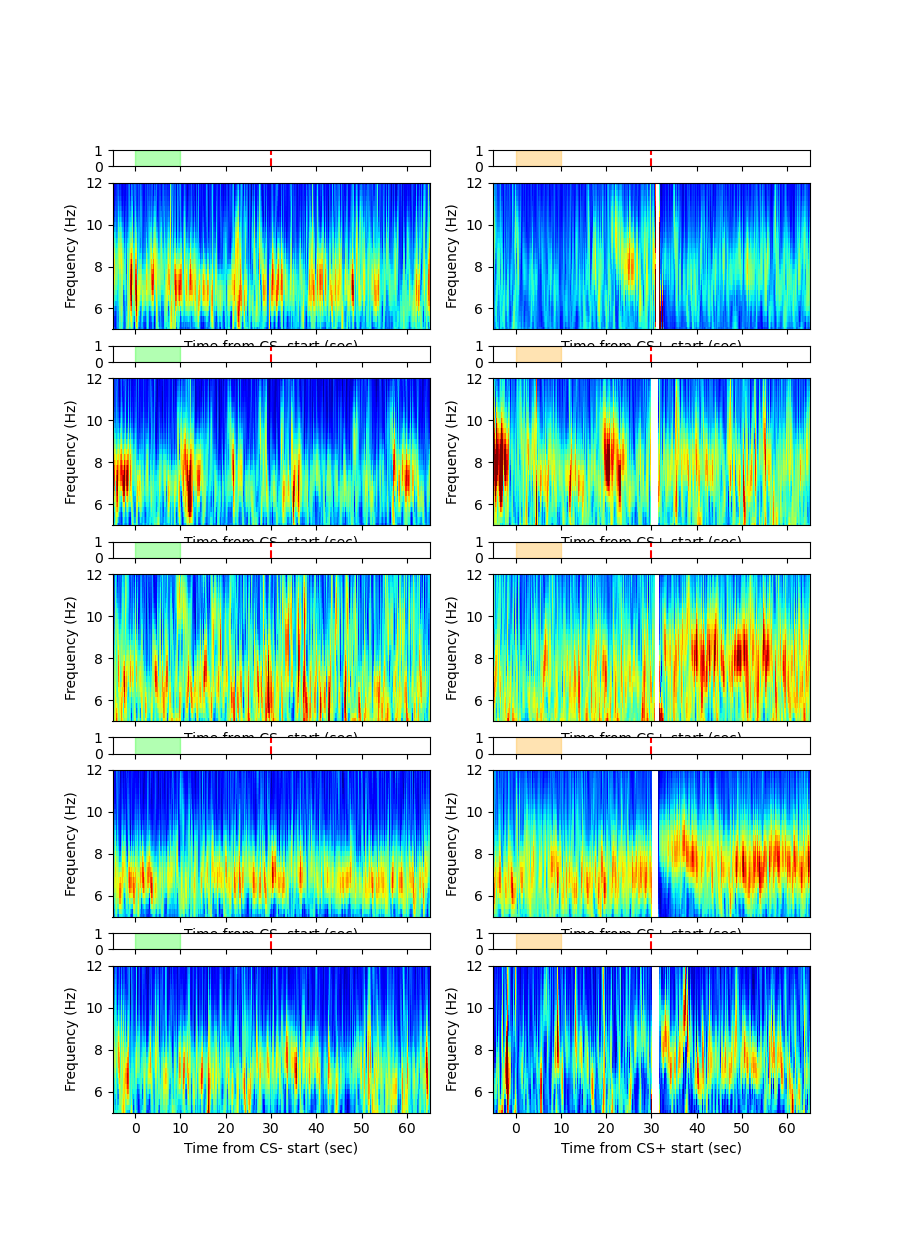

In [33]:
# Now try plotting!
%matplotlib widget
from tracefc.plotting.signals import plot_cs_mean_wavelet

theta_freq_lims = (5, 12)
nsesh = len(sess_list)
_, ax = plt.subplots(nsesh*2, 2, figsize=(9, 2.5*nsesh), height_ratios=[1, 9]*nsesh, sharex=True)

wv_mean_comb = []
for ids, sess in enumerate(sess_list):
    wv_comb_sesh = []
    for idc, (cs_name, cs_type) in enumerate(zip(('CS-', 'CS+'), ('csn', 'cs'))):
        cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
        wv_mean_use = getattr(sess, f"wv_theta_mean_{cs_type}")
        wv_comb_sesh.append(wv_mean_use.traces)
        std_sxx = None if idc == 0 else std_sxx
        _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
                                          freq_lims=theta_freq_lims, calc_mean=False, std_sxx=std_sxx, 
                                          ax=ax[range(ids*2, (ids+1)*2), idc])
    wv_mean_comb.append(wv_comb_sesh)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

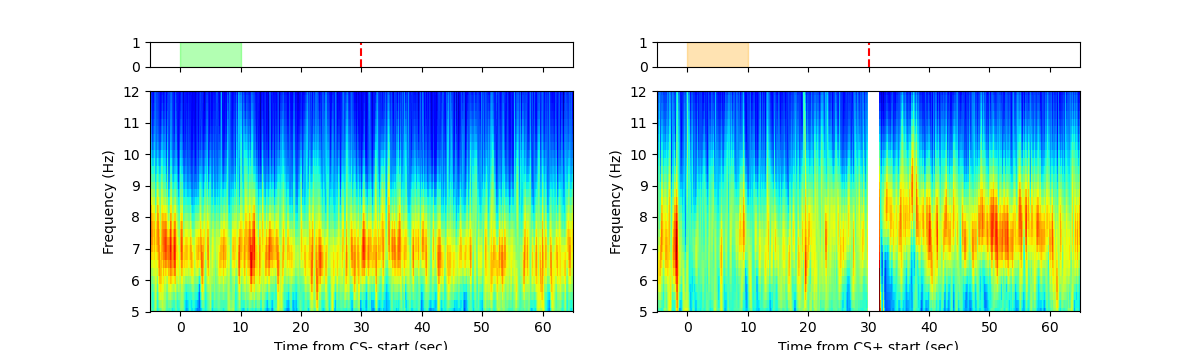

In [40]:
from copy import deepcopy
_, ax = plt.subplots(2, 2, height_ratios = [1, 9], sharex=True, figsize=(12, 3.5))
comb_mean = np.array(wv_mean_comb).mean(axis=0)

wv_mean_use = deepcopy(wv_mean_use)
wv_mean_use.traces = wv_mean_comb_mean[0]
_, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type='CS-', buffer_sec=buffer_sec, 
                                          freq_lims=theta_freq_lims, calc_mean=False, std_sxx=None, 
                                          ax=ax[:,0])
wv_mean_use = deepcopy(wv_mean_use)
wv_mean_use.traces = wv_mean_comb_mean[1]
_, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type='CS+', buffer_sec=buffer_sec, 
                                          freq_lims=theta_freq_lims, calc_mean=False, std_sxx=std_sxx, 
                                          ax=ax[:,1])


# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [ ]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

In [ ]:
%matplotlib widget

chan_plot = 31
plot_signal_w_epochs(signal, chan_plot, art_epochs)

In [ ]:
### Code below to modify epochs manually if necessary

In [ ]:
# # Delete art epochs between certain times
t1 = [818]
t2 = [821]
for tstart, tstop in zip(t1, t2):
    art_epochs = art_epochs.delete_in_between(t1=tstart, t2=tstop)

sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
art_epochs.save(art_epochs_file)

In [ ]:
# Add in epochs manually after inspection in neuroscope - then re-run above to check!

# individual epoch
# t1 = 10767.3
# t2 = 10768.7
# art_epochs = art_epochs.add_epoch_manually(t1, t2)

# List of epochs
# epochs_to_add =np.array([[3354, 3355.5], [2666, 2669]])
# art_epochs = art_epochs.add_epoch_manually(epochs_to_add[:, 0], epochs_to_add[:, 1])
# sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
# art_epochs.save(art_epochs_file)

In [ ]:
# Rose recall has lots of channels wandering around.

### Code below to import updated epochs after manual adjustment in Neuroscope!

In [ ]:
# Note that Neuroscope is super buggy with adding events to existing files! One tactic is to create an .ar2 file and then add 
# in any adjustments then merge.

# art_epochs_ns = sess.recinfo.event_to_epochs(evt_file=sess.filePrefix.with_suffix('.evt.ar2'))
# art_epochs_ns

In [ ]:
# Merge files and export!
# art_epochs_merge = art_epochs.__add__(art_epochs_ns).merge(0)
# art_epochs_merge.save(art_epochs_file)
# art_epochs = art_epochs_merge
# sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
# art_epochs

## Define probe group

In [ ]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [ ]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 25

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

## Detect SWR Epochs

In [ ]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 25
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

In [ ]:
t = np.load(sess.filePrefix.with_suffix(".ripple_epochs.npy"), allow_pickle=True)
t.item()["metadata"]

# Wavelet Analysis

### Start with Theta

In [ ]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

In [ ]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

In [ ]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [ ]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

In [ ]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

In [ ]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-CS analyses

In [ ]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [ ]:
import tracefc.io.traceio as traceio

process_csn, process_cs, process_cs2 = True, True, True  # set flags for running code below
if sess_name.find("recall") == 0:
    # For tone recall CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} tone recall')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} control tone recall')
    print(csn_starts.head(6))
    
    # For CS+ at end of control_tone_recall
    cs2_starts, cs2_ends, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs2_starts.shape[0]} CS+ events detected during {sess_name} control tone recall')
    print(cs2_starts.head(6))
elif sess_name.find("habituation") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    process_cs, process_cs2 = False, False
    
elif sess_name.find("training") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    # For training CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} training')
    print(cs_starts.head(6))

    process_cs2 = False
    

In [ ]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

In [ ]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(2, unit="seconds")

# CS+
if process_cs:
    cs_oe_start_df, cs_start_diff = traceio.trace_ttl_to_openephys(cs_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use, return_diff=True)
    # Convert to times in combined eeg file
    cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)

    cs_oe_stop_df, cs_stop_diff = traceio.trace_ttl_to_openephys(cs_ends, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use, return_diff=True)
    # Convert to times in combined eeg file
    cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

    # Export to neuroscope
    cs_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ""})
    sess.recinfo.write_epochs(cs_epochs, ext="csp")

    # Save to neuropy
    cs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
    cs_epochs.save(cs_file)

# CS-
csn_oe_start_df, csn_start_diff = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2, return_diff=True)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)

csn_oe_stop_df, csn_stop_diff = traceio.trace_ttl_to_openephys(csn_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2, return_diff=True)

# Convert to times in combined eeg file
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

# Export to neuroscope
csn_epochs = Epoch({"start": csn_starts_combined, "stop": csn_stops_combined, "label": ""})
sess.recinfo.write_epochs(csn_epochs, ext="csn")

# Save to neuropy
csn_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
csn_epochs.save(csn_file)


# CS+ 2
if process_cs2:
    cs2_oe_start_df = traceio.trace_ttl_to_openephys(cs2_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs2_starts_combined = oeio.recording_events_to_combined_time(cs2_oe_start_df, sync_df)

    cs2_oe_stop_df = traceio.trace_ttl_to_openephys(cs2_ends, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs2_stops_combined = oeio.recording_events_to_combined_time(cs2_oe_stop_df, sync_df)

    # Export to neuroscope
    cs2_epochs = Epoch({"start": cs2_starts_combined, "stop": cs2_stops_combined, "label": ""})
    sess.recinfo.write_epochs(cs2_epochs, ext="cs2")

    # Save to neuropy
    cs2_file = sess.filePrefix.with_suffix(".cs2_epochs.npy")
    cs2_epochs.save(cs2_file)


## Theta mean spectrogram

In [ ]:
from tracefc.plotting.signals import plot_cs_mean_wavelet
cs_buffer = (5, 45)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_theta, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

if sess_name.find("training") == 0: # for training sessions
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])

    # Change red line to solid
    line_ind = np.where([isinstance(a, plt.Line2D) for a in ax[0].get_children()])[0][0]
    ax[0].get_children()[line_ind].set_linestyle('-')
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[1, 5], layout='tight', sharex=True)

    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Ripple mean spectrogram

In [ ]:
cs_buffer = (5, 45)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_swr, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

elif sess_name.find("training") == 0:
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    # Change red line to solid
    line_ind = np.where([isinstance(a, plt.Line2D) for a in ax[0].get_children()])[0][0]
    ax[0].get_children()[line_ind].set_linestyle('-')
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[1, 5], layout='tight', sharex=True)
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Save notebook to working directory

In [ ]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")